In [19]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('./deeplearning.mplstyle')
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from lab_utils_common import dlc
from lab_coffee_utils import load_coffee_data, plt_roast, plt_prob, plt_layer, plt_network, plt_output_unit
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)
tf.autograph.set_verbosity(0)

In [20]:
X,Y = load_coffee_data();
print(X.shape, Y.shape)

(200, 2) (200, 1)


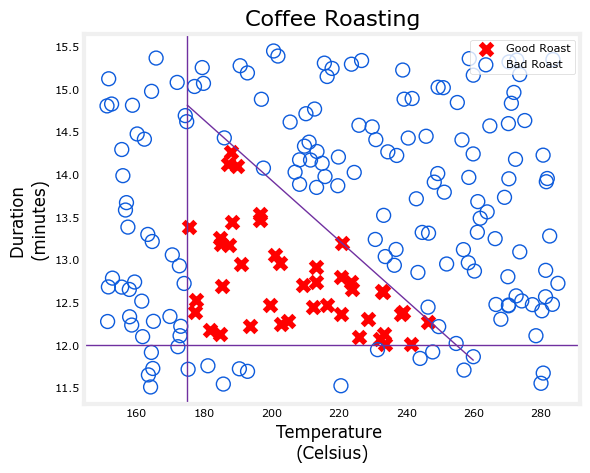

In [21]:
plt_roast(X,Y)

here, now we need to normalize the data that lets the computations be much faster, the computations are much faster because the data are in a similar range

PRE NORMALIZATION

In [22]:
print(f"Temperature Max, Min pre normalization: {np.max(X[:,0]):0.2f}, {np.min(X[:,0]):0.2f}")
print(f"Duration    Max, Min pre normalization: {np.max(X[:,1]):0.2f}, {np.min(X[:,1]):0.2f}")

Temperature Max, Min pre normalization: 284.99, 151.32
Duration    Max, Min pre normalization: 15.45, 11.51


Now we use keras for normalization

In [23]:
norm_l = tf.keras.layers.Normalization(axis=-1)
norm_l.adapt(X)  # learns mean, variance
Xn = norm_l(X)

after normalization our data looks like

In [24]:
print(f"Temperature Max, Min post normalization: {np.max(Xn[:,0]):0.2f}, {np.min(Xn[:,0]):0.2f}")
print(f"Duration    Max, Min post normalization: {np.max(Xn[:,1]):0.2f}, {np.min(Xn[:,1]):0.2f}")

Temperature Max, Min post normalization: 1.66, -1.69
Duration    Max, Min post normalization: 1.79, -1.70


now we need to tile our dataset so that our model learns better with each epoch
NOTE: tiling is just copying the ssame data, even if the data is not new, with each epoch the model learns better

In [25]:
Xt = np.tile(Xn,(1000,1))
Yt= np.tile(Y,(1000,1))   
print(Xt.shape, Yt.shape)   

(200000, 2) (200000, 1)


now we are going to write the code for the model using tensorflow
# DESCRIPTION OF OUR MODEL
1. There are going to be __2 layers__ with __sigmoid activation__.
2. The initial input will be x vector.
3. The first layer will have __3 units__ and the second layer will have a __single__ unit.
4. The activation given by the first layer will be __a[1]__ and the second layer will give the final output value __a[2]__ which will be our final output, after that it can be compared to see whether the roast has been complete or not.

In [26]:
tf.random.set_seed(1234)
model = Sequential(
    [
        tf.keras.Input(shape=(2,)),
        Dense(3, activation='sigmoid', name = 'layer1'),
        Dense(1, activation='sigmoid', name = 'layer2')
     ]
)

## NOTE
__There are a couple of things to understand:__
1. __tf.Keras.Input__ specifies the expected shape of the output. This is not necessary in practical and this is addressed in model.fit() function when input is provided.
2. It is also not best practice to keep the last layer as a sigmoid layer. Including the sigmoid activation in the final layer is not considered best practice. It would instead be accounted for in the loss which improves numerical stability.

In [27]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ layer1 (Dense)                  │ (None, 3)              │             9 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer2 (Dense)                  │ (None, 1)              │             4 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13 (52.00 B)

 Trainable params: 13 (52.00 B)

 Non-trainable params: 0 (0.00 B)

## NOTE
The params here are attained by a simple rule, the layer 1 has 9 params and it is achieved through
__number of input variables=2__
__number of output variables=3__
__number of neurons in that layer=3__
now the total parameter can be calculated by
__2*3+3=9__

In [28]:
L1_num_params = 2 * 3 + 3   # W1 parameters  + b1 parameters
L2_num_params = 3 * 1 + 1   # W2 parameters  + b2 parameters
print("L1 params = ", L1_num_params, ", L2 params = ", L2_num_params  )

L1 params =  9 , L2 params =  4


### In order to know the weights of each layer

In [29]:
W1, b1 = model.get_layer("layer1").get_weights()
W2, b2 = model.get_layer("layer2").get_weights()
print(f"W1{W1.shape}:\n", W1, f"\nb1{b1.shape}:", b1)
print(f"W2{W2.shape}:\n", W2, f"\nb2{b2.shape}:", b2)

W1(2, 3):
 [[-0.27 -0.25 -0.15]
 [-0.8   0.55 -0.09]] 
b1(3,): [0. 0. 0.]
W2(3, 1):
 [[ 1.03]
 [-0.1 ]
 [ 0.96]] 
b2(1,): [0.]


## TO COMPILE THE MODEL
1. Here a loss function is determined for the model, here we will use binarycrossentropy() which is suitable for tasks like binary classification where data are classified in terms of 0 and 1
2.This specifies the optimizer used for updating the model weights based on the computed gradients during training. also specifies a learning rate. The higher the learning rate the faster an epoch is completed but there are chances the gradient descent doesnt reach its sweet spot with high learning rate.

In [30]:
model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.01),
)

## To fit the model
The model.fit statement runs gradient descent and fits the weights to the data.

In [31]:
model.fit(
    Xt,Yt,            
    epochs=10,
)

Epoch 1/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 2s 240us/step - loss: 0.3140
Epoch 2/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 1s 238us/step - loss: 0.1331
Epoch 3/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 2s 239us/step - loss: 0.1215
Epoch 4/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 1s 237us/step - loss: 0.1084
Epoch 5/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 1s 236us/step - loss: 0.0264
Epoch 6/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 1s 236us/step - loss: 0.0145
Epoch 7/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 2s 241us/step - loss: 0.0098
Epoch 8/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 1s 236us/step - loss: 0.0069
Epoch 9/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 2s 240us/step - loss: 0.0049
Epoch 10/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 2s 238us/step - loss: 0.0036


after fitting the weights have been updated, previously the biases were 0 but after fit we get new biases

In [33]:
W1, b1 = model.get_layer("layer1").get_weights()
W2, b2 = model.get_layer("layer2").get_weights()
print("W1:\n", W1, "\nb1:", b1)
print("W2:\n", W2, "\nb2:", b2)

W1:
 [[-1.73e+01 -2.13e-03 -1.06e+01]
 [-1.45e+01 -8.54e+00 -1.81e-01]] 
b1: [ -2.55 -10.68 -11.59]
W2:
 [[ 32.2 ]
 [-40.55]
 [-44.84]] 
b2: [-8.94]


# PREDICTIONS
As we have trained our model, now we can use it to make predictions

In [34]:
X_test = np.array([
    [200,13.9],  # positive example
    [200,17]])   # negative example
X_testn = norm_l(X_test)
predictions = model.predict(X_testn)
print("predictions = \n", predictions)

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
predictions = 
 [[9.53e-01]
 [1.27e-04]]


In [35]:
yhat = np.zeros_like(predictions)
for i in range(len(predictions)):
    if predictions[i] >= 0.5:
        yhat[i] = 1
    else:
        yhat[i] = 0
print(f"decisions = \n{yhat}")

decisions = 
[[1.]
 [0.]]


We can also know how each layer and unit have affected the change

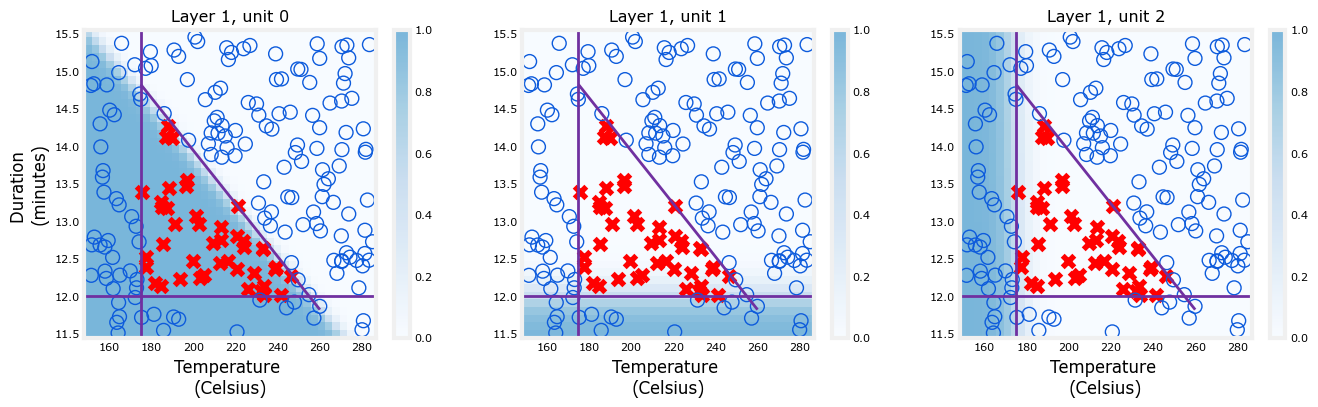

In [36]:
plt_layer(X,Y.reshape(-1,),W1,b1,norm_l)

Here, layer 1 unit 0 is more concerned with data that have low temp, unit 1 seems to be concerned with low duration and unit 2 is more concerned with bad fits or edge case